#NinaPro DB5 dataset(電極番号1~8)

ジェスチャ：6種類

準拠するパラメータ：

・batch size = 128

・L2正則化の重み = 0.001

・学習率減衰：1~19 = 0.01, 20~39 = 0.001, 40~50 = 0.0001

・データ比：train:valid:test = 6:1:3

In [1]:
!nvidia-smi

Wed Dec 21 13:15:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   32C    P8    20W / 350W |  24043MiB / 24576MiB |     26%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

dataset
バッチサイズ→128
テストデータ割合→10%

データセットの解凍

In [2]:
#import keras
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten
#from tensorflow.keras.layers.advanced_activations import PReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler #学習率減衰
from tensorflow.keras import regularizers #L2正則化
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import tensorflow as tf
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'#GPUのメモリ確保を制限

#乱数の設定
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(1)
np.random.seed(1)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

各種設定(データセットの指定など)

In [3]:
train_data_path = 'datasetNina_ExB_2' #データセットのフォルダ名
folder = list(map(str, range(1, 7))) #データセットのクラス名

class_number = len(folder)
print('今回のデータで分類するクラス数は「', str(class_number), '」です。')

今回のデータで分類するクラス数は「 6 」です。


データセットの読み込み・準備

In [4]:
start = time.time()
X_image = []
Y_label = []
Xappend = X_image.append
Yappend = Y_label.append

#クラスごとのループ
for index, name in enumerate(folder): #name:クラスフォルダ名, index:クラスに対応している変数
  read_data = train_data_path + '/' + name

  files = glob.glob(read_data + '/*.npy') #クラスごとのファイルすべてを格納
  #print('--- 読み込んだデータセットは', read_data, 'です。')

  #ファイルごとのループ
  for i, file in enumerate(files):  #i:クラス内の各ファイルに対応している変数
    print('\r', read_data, ': ', i+1, '/', len(files), end='')
    array = np.load(file)

    Xappend(array) #画像データをndarrayとして格納
    Yappend(index) #画像に対応したクラス(画像ラベル)を格納

  print(' --finish: ' + str(int((time.time()-start)/60)) + 'm' + str(int((time.time()-start))%60) + 's')
  
#データセット配列の設定
X_image = np.array(X_image) #データセット全体の画像行列データ＝入力データ
Y_label = np.array(Y_label) #データセット全体の画像ラベル

#画像行列データを正規化
print(X_image.max(), X_image.min())
scale = (X_image.max() - X_image.min())/2
med = (X_image.max() + X_image.min())/2
X_image = (X_image - med)/scale
print(X_image.max(), X_image.min())

Y_label = to_categorical(Y_label, class_number) #Kerasではクラスをベクトルで扱うらしい【おまじない】

#訓練データとテストデータを分割。
x_train, valid_images, y_train, valid_labels = train_test_split(X_image, Y_label, test_size=0.4, random_state=0)
x_valid, x_test, y_valid, y_test = train_test_split(valid_images, valid_labels, test_size=0.75, random_state=0)

print('train data size: ', len(x_train))
print('valid data size: ', len(x_valid))
print('test data size: ', len(x_test))

 datasetNina_ExB_2/1 :  9534 / 9534 --finish: 0m39s
 datasetNina_ExB_2/2 :  7892 / 7892 --finish: 1m13s
 datasetNina_ExB_2/3 :  7954 / 7954 --finish: 1m47s
 datasetNina_ExB_2/4 :  8105 / 8105 --finish: 2m23s
 datasetNina_ExB_2/5 :  7072 / 7072 --finish: 2m54s
 datasetNina_ExB_2/6 :  7231 / 7231 --finish: 3m26s
462.4565211200414 -183.13786906912753
1.0 -1.0
train data size:  28672
valid data size:  4779
test data size:  14337


ch数(1~7)を指定したCNNモデル

In [5]:
BATCH_SIZE = 128
image_size_x = 25 #画像サイズ
image_size_y = 15
channel = 8 
epochnumber = 50
L2weight = 0.001 #Myo: 0.01, Nina: 0.001

#CNNアーキテクチャの設計
model = Sequential()

model.add(BatchNormalization(input_shape=(image_size_x, image_size_y, channel)))
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3), padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))

model.add(GlobalAveragePooling2D())

model.add(Dense(class_number, activation='softmax', kernel_regularizer=regularizers.l2(L2weight)))

#model.summary()

#学習率減衰の設定
def step_decay(epoch):
    x = 0.01
    if epoch >= 20: x = 0.001
    if epoch >= 40: x = 0.0001
    return x
lr_decay = LearningRateScheduler(step_decay)

model.compile(loss='categorical_crossentropy', #損失関数の設定
            optimizer=Adam(learning_rate=0.01), #最適化アルゴリズムの設定
            metrics=['accuracy'] #評価関数の設定
            )

start_time = time.time()

#可視化
history = model.fit(x_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=epochnumber, 
                    verbose=1, #学習過程を出力するかどうか
                    validation_data=(x_valid, y_valid), 
                    callbacks=[lr_decay] #学習率減衰の設定
                    )

print('Computation time: {0:.3f} sec'.format(time.time() - start_time))

model.save('model/EMGNet_Nina_B6_2.h5') #モデルの保存


Epoch 1/50
224/224 [==============================] - 4s 9ms/step - loss: 1.1318 - accuracy: 0.5605 - val_loss: 2.2941 - val_accuracy: 0.3040 - lr: 0.0100
Epoch 2/50
224/224 [==============================] - 2s 8ms/step - loss: 0.9076 - accuracy: 0.6561 - val_loss: 1.0592 - val_accuracy: 0.6066 - lr: 0.0100
Epoch 3/50
224/224 [==============================] - 2s 8ms/step - loss: 0.8210 - accuracy: 0.6887 - val_loss: 0.7804 - val_accuracy: 0.7064 - lr: 0.0100
Epoch 4/50
224/224 [==============================] - 2s 8ms/step - loss: 0.7692 - accuracy: 0.7100 - val_loss: 0.9692 - val_accuracy: 0.6616 - lr: 0.0100
Epoch 5/50
224/224 [==============================] - 2s 8ms/step - loss: 0.7387 - accuracy: 0.7219 - val_loss: 0.8230 - val_accuracy: 0.6947 - lr: 0.0100
Epoch 6/50
224/224 [==============================] - 2s 8ms/step - loss: 0.6978 - accuracy: 0.7367 - val_loss: 0.7493 - val_accuracy: 0.7190 - lr: 0.0100
Epoch 7/50
224/224 [==============================] - 2s 8ms/step - lo

学習曲線の作図(保存したモデルを呼び出して実行)

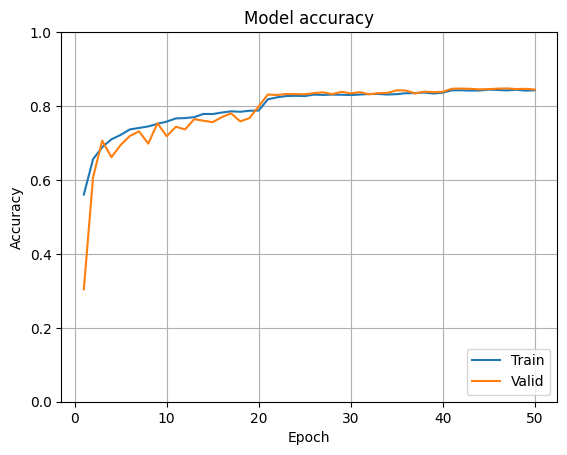

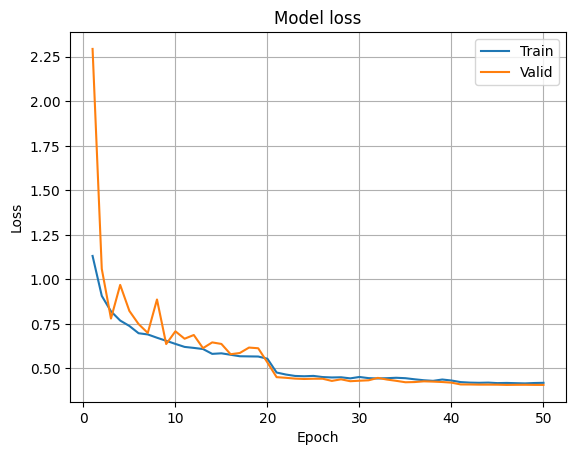

In [6]:
model = load_model('model/EMGNet_Nina_B6_2.h5')

#作図
x = range(1, epochnumber+1)
plt.plot(x, history.history['accuracy'])
plt.plot(x, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Valid'], loc='lower right')
plt.show()

plt.plot(x, history.history['loss'])
plt.plot(x, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
#plt.ylim(0, 8)
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

テスト・混同行列の作成(参考：https://newtechnologylifestyle.net/keras_fashion-mnist/)(https://kinpatucom821.hatenablog.com/entry/2018/08/30/215419)

449/449 [==============================] - 1s 1ms/step
Confusion matrix, without normalization
[[2607   48   19   43   23   64]
 [ 122 1940  139   89   32   39]
 [  50  190 2027   45   41   23]
 [  90   89   34 1889  349   13]
 [  46   33   34  268 1743   18]
 [  93   41   20   40   33 1963]]


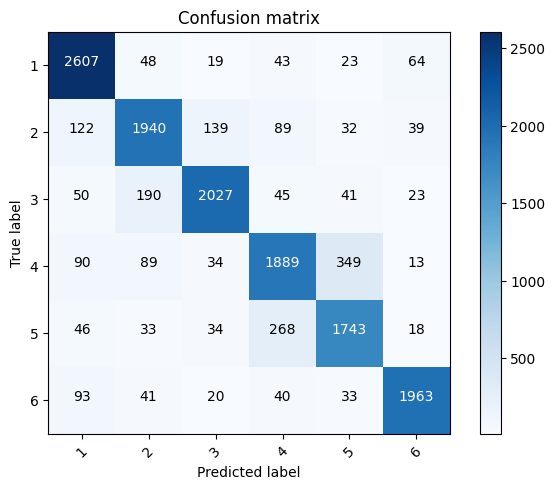

Loss: 0.4115522503852844 （損失関数値 - 0に近いほど正解に近い）
Accuracy: 84.87828969955444 % （精度 - 100% に近いほど正解に近い）


In [7]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

pred_y = model.predict(x_test)
pred_y_classes = np.argmax(pred_y,axis = 1) 
tue_y= np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(tue_y, pred_y_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(1, 7)) 
plt.show()

score = model.evaluate(x_test, y_test, verbose=0)
print('Loss:', score[0], '（損失関数値 - 0に近いほど正解に近い）') 
print('Accuracy:', score[1] * 100, '%', '（精度 - 100% に近いほど正解に近い）') 

Normalized confusion matrix
[[0.89634703 0.01872146 0.01826484 0.04246575 0.00913242 0.01506849]
 [0.01651842 0.82168573 0.03769589 0.05167302 0.05887336 0.01355358]
 [0.00527597 0.03612013 0.76663961 0.03652597 0.0137987  0.14163961]
 [0.02282454 0.0171184  0.01533524 0.92974322 0.00677603 0.00820257]
 [0.00968013 0.07996633 0.01893939 0.02104377 0.85311448 0.01725589]
 [0.00840336 0.01540616 0.12511671 0.02147526 0.01587302 0.81372549]]


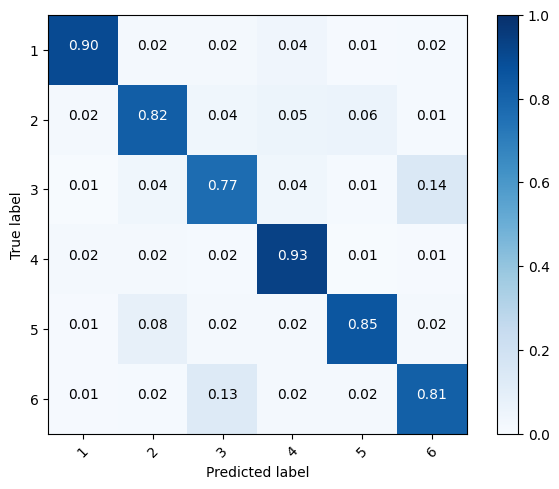

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

#model = load_model('model/EMGNet_Nina_B6_1.h5')

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_mtx = [[2607,   48,   19,   43,   23,   64],
                 [ 122, 1940,  139,   89,   32,   39],
                 [  50,  190, 2027,   45,   41,   23],
                 [  90,   89,   34, 1889,  349,   13],
                 [  46,   33,   34,  268, 1743,   18],
                 [  93,   41,   20,   40,   33, 1963]]
mtx = np.array(confusion_mtx)
mtx = mtx[[5,1,3,0,2,4]]
mtx = mtx[:,[5,1,3,0,2,4]]

plot_confusion_matrix(mtx, classes = range(1, 7)) 
plt.show()